# Building a Tree Classifier

For this exercise, we'll only focus on classifying Bonsai, Palm, and Willow trees.

In [113]:
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastai.vision.widgets import *
from duckduckgo_search import DDGS
from fastdownload import download_url


The basic steps we'll take are:

1. Use DuckDuckGo to search and store images of Bonsai, Palm, and Willow trees

2. Fine-tune a pretrained neural network to recognise these three groups

3. Evaluate the model performance and exploring ways to enhance the accuracy

4. Export the model, make an app out of it, and ready it for deployment

## Step 1: Download the tree images

In [63]:
def search_images(keywords, max_images=200): return L(DDGS().images(keywords,max_results=max_images)).itemgot('image')

In [64]:
urls = search_images('bonsai tree', max_images=1)
urls[0]

'https://www.thespruce.com/thmb/0AJv8AfVaT09o4oLhofX_WR_d-Y=/3024x3022/filters:no_upscale():max_bytes(150000):strip_icc()/Bonsai-Juniper-Tree_GettyImages-1191078639-c86fffdd513648b6b2ee0d658710bc7d.jpg'

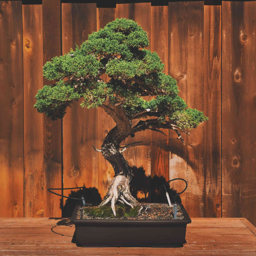

In [7]:
dest = 'bonsai.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)

Everything seems to be in order so we will go ahead and download the trees

In [65]:
searches = 'Palm','Willow','Bonsai'
path = Path('trees')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} tree',max_images = 125))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Some images don't download properly so we need to filter them out to be able to properly train our model

In [66]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

## Step 2: Train our model

In [67]:
trees = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(128)],
   # batch_tfms=aug_transforms(mult=1)
   batch_tfms = [RandomResizedCrop(128, min_scale=0.35), Flip(), Brightness(), Contrast(), Rotate(max_deg=10.0)]

)
dls = trees.dataloaders(path)


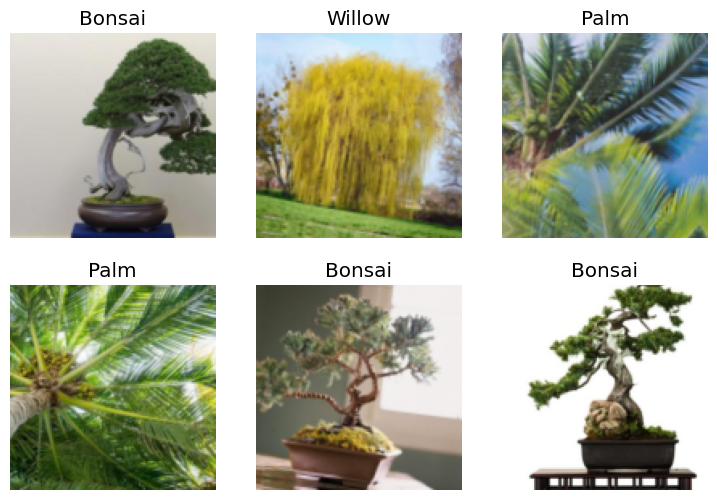

In [68]:
dls.show_batch(max_n=6)

In [73]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.612577,0.600011,0.223881,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.453348,0.144135,0.059701,00:00
1,0.355663,0.027839,0.014925,00:00
2,0.255866,0.021154,0.014925,00:00


Running a few more epochs may increase accuracy in our case

## Step 3: Evaluating our model

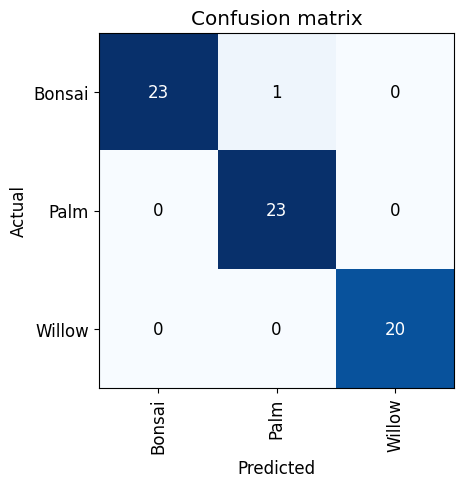

In [74]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

From the the confusion matrix we can see that our model did pretty well on our validation set. 

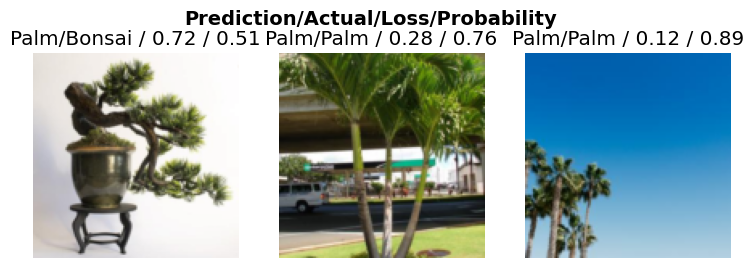

In [75]:
interp.plot_top_losses(3, nrows=1)

To take a deeper look into our performance, we plotted some images that our model guessed incorrectly and wasn't very confident of. The next few blocks of code can be used to fix those inaccuracies and enhance the model accuracy. 

In [85]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#to delete/fix the labels run code below

# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Step 4: Exporting our model and making a small application

The following cells show us how we can export our model to a .pkl file that can be stored and used to create an app using IPython widgets

In [86]:
#export
learn.export()

In [87]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [88]:
learn_inf = load_learner(path/'export.pkl')

In [91]:
learn_inf.predict('bonsai.jpg')

('Bonsai', tensor(0), tensor([1.0000e+00, 2.0417e-06, 3.8929e-07]))

In [92]:
learn_inf.dls.vocab

['Bonsai', 'Palm', 'Willow']

In [103]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [104]:
img = PILImage.create(btn_upload.data[-1])

In [105]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [106]:
pred,pred_idx,probs = learn_inf.predict(img)

In [107]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Palm; Probability: 0.9999')

In [108]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [109]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [110]:
btn_upload = widgets.FileUpload()

In [112]:
VBox([widgets.Label('Select your tree!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

Now that we have set everything up, the model is ready for deployment (GitHub and Binder can be used for this ).